In [1]:
import io
import re
import glob
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

In [2]:
plt.style.use('ggplot')

In [3]:
def get_root_node(filename):
    buf = io.StringIO()
    
    with open(filename, 'r') as fh:
        while line := fh.readline():
            if re.search(r'\<\??xml', line):
                continue
            
            line = re.sub(r' xmlns=".*?"', ' ', line.strip())
            buf.write(line)
            buf.write('\n')
    
    buf.seek(0)
    
    tree = ET.parse(buf)
    return tree.getroot()

In [4]:
def get_coords(filename):
    root = get_root_node(filename)

    time_sec = 0
    dist_m = 0
    laps = root.findall('.//Lap')
    for lap in laps:
        time_sec += float(lap.find('TotalTimeSeconds').text)
        dist_m += float(laps[0].find('DistanceMeters').text)

    when = root.find('.//Lap').get('StartTime')
    dt = datetime.datetime.strptime(when[:19], '%Y-%m-%dT%H:%M:%S')
    dt_fmt = dt.strftime('%b %d, %y @ %I:%M') + dt.strftime('%p').lower()
    
    locs = []
    for node in root.findall('.//Trackpoint'):
        p = node.find('Position')
        lat = p.find('LatitudeDegrees').text
        lon = p.find('LongitudeDegrees').text
        alt = node.find('AltitudeMeters').text
        bpm = node.find('HeartRateBpm/Value').text

        locs.append((float(lat), float(lon), float(alt), float(bpm)))
    df = pd.DataFrame(locs, columns=['Lat', 'Lon', 'Altitude', 'BPM'])
    df.loc[:, 'TotalTimeSec'] = time_sec
    df.loc[:, 'TotalDistM'] = dist_m
    df.loc[:, 'DateTime'] = dt_fmt
    return df

In [5]:
def calc_zones(vals):
    zones = [
        [0, 99],
        [99, 115],
        [115, 132],
        [132, 149],
        [149, 999],
    ]
    matches = []
    for val in vals:
        for i, (a, b) in enumerate(zones):
            if val >= a and val < b:
                matches.append(i+1)
                break
    return pd.Series(matches, name='Zones')

In [6]:
runs = sorted(glob.glob('*.tcx'))

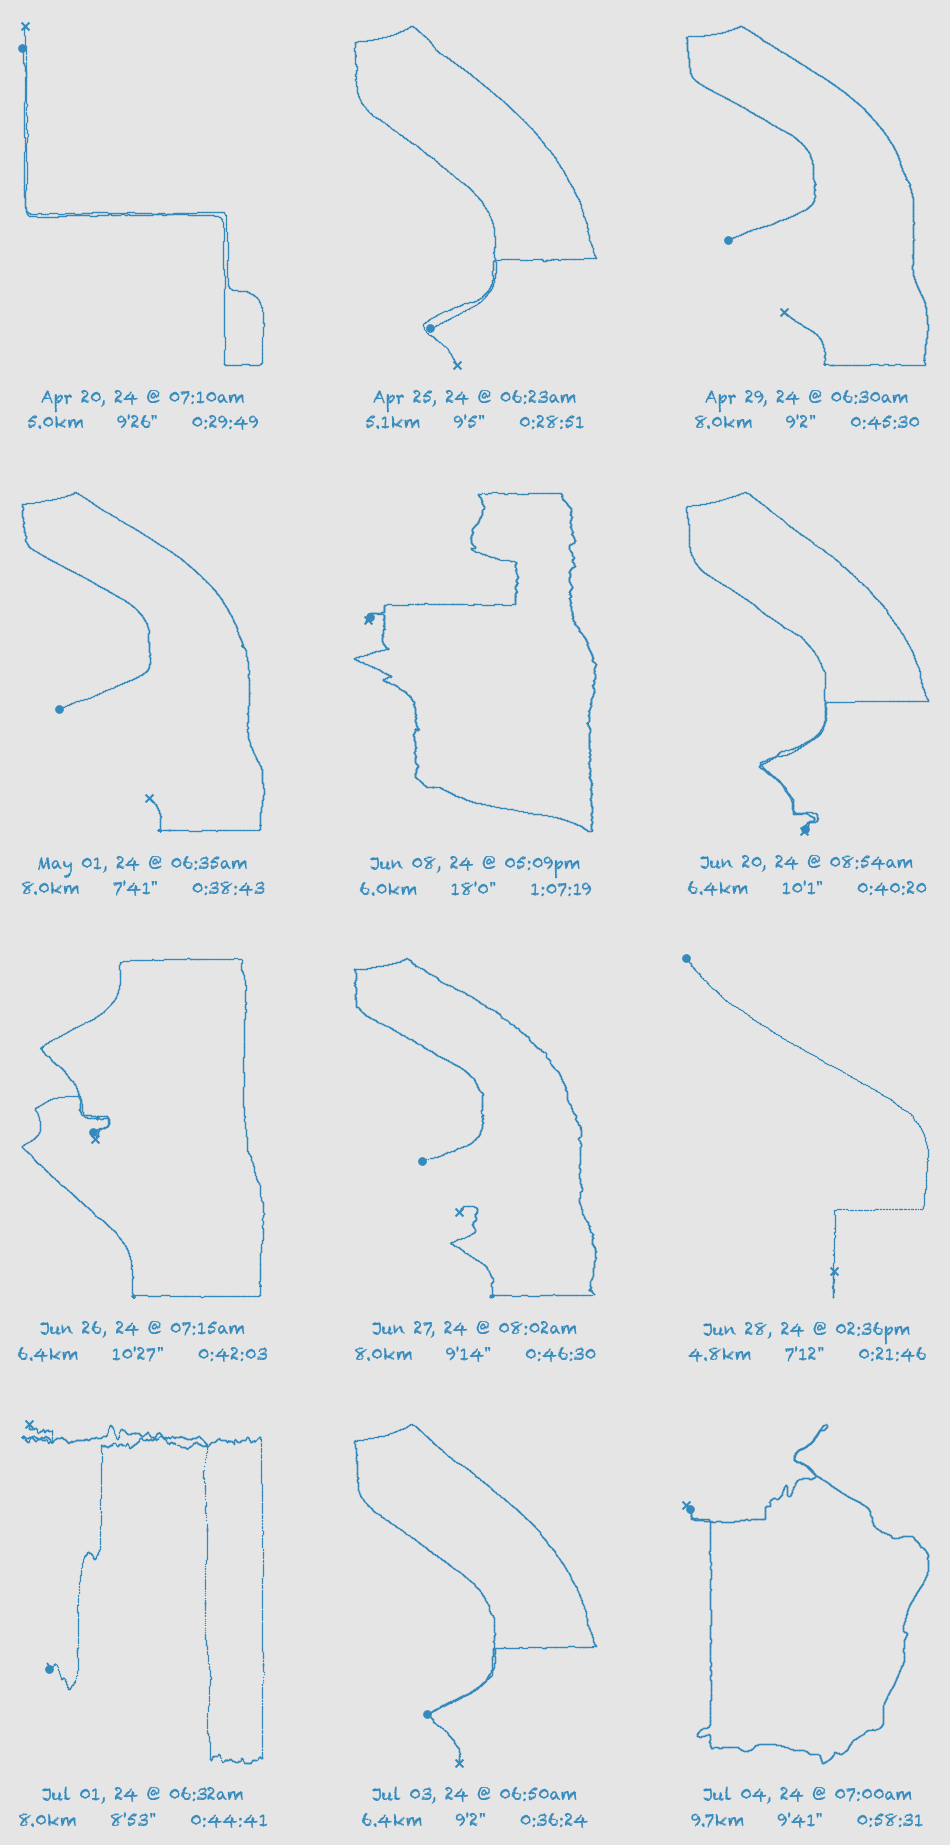

In [7]:
fig, axes = plt.subplots(4, 3, figsize=(12, 23))
ax_flat = [c for r in axes for c in r]
for i, run in enumerate(runs):
    df = get_coords(run)
    ax = df.plot.scatter(x='Lon', y='Lat', s=0.25, grid=False, ax=ax_flat[i])
    df.iloc[:1].plot.scatter(x='Lon', y='Lat', marker='o', color='C1', ax=ax, s=32.5)
    df.iloc[-1:].plot.scatter(x='Lon', y='Lat', marker='x', color='C1', ax=ax, s=32.5)

    # ---

    dist_fmt = f'{df.iloc[0].TotalDistM / 1000:.2}km'

    pace = (df.iloc[0].TotalTimeSec / 60) / df.iloc[0].TotalDistM * 1000 * 1.6
    pace_min = int(pace)
    pace_sec = int(float('0.' + str(pace).split('.')[1]) * 60)
    pace_fmt = str(f'{pace_min}\'{pace_sec}"')
    
    time_total = df.iloc[0].TotalTimeSec
    hours, remainder = divmod(time_total, 3600)
    minutes, seconds = divmod(remainder, 60)
    time_fmt = f'{int(hours)}:{int(minutes):02}:{int(seconds):02}'

    # ---

    # ax.set_title(df.iloc[0].DateTime, color='C1', fontfamily='Chalkduster', fontsize=11)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel('')
    ax.set_xlabel(f'{df.iloc[0].DateTime}\n{dist_fmt}    {pace_fmt}    {time_fmt}', color='C1', fontfamily='Chalkduster')

    for spine in ax.spines.values():
        spine.set_visible(False)


fig.patch.set_facecolor('#e5e5e5')
fig.subplots_adjust(wspace=0.25, hspace=0.25)
# fig.tight_layout()